 ## **Training MobileNetSSD Object Detection Using RoboFlow and Google Colab**

In [ ]:
# Forked repo link.
repo_url = 'https://github.com/jaco-lau/tensorflow-object-detection-faster-rcnn'

# Number of training steps
num_steps = 200000

# Number of evaluation steps.
num_eval_steps = 50

MODELS_CONFIG = {
    'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_coco_2018_03_29',
        'pipeline_file': 'ssd_mobilenet_v2_coco.config',
        'batch_size': 12
    },
    'faster_rcnn_inception_v2': {
        'model_name': 'faster_rcnn_inception_v2_coco_2018_01_28',
        'pipeline_file': 'faster_rcnn_inception_v2_pets.config',
        'batch_size': 12
    },
    'rfcn_resnet101': {
        'model_name': 'rfcn_resnet101_coco_2018_01_28',
        'pipeline_file': 'rfcn_resnet101_pets.config',
        'batch_size': 8
    },    
}

# Select a model in `MODELS_CONFIG`.
selected_model = 'ssd_mobilenet_v2'

# Name of the object detection model to use.
MODEL = MODELS_CONFIG[selected_model]['model_name']

# Name of the pipline file in tensorflow object detection API.
pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']

# Training batch size fits in Colab's GPU memory for selected model.
batch_size = MODELS_CONFIG[selected_model]['batch_size']

In [ ]:
# use TF 1.x for Object Detection APIs as they are not ported to TF 2.0 yet
%tensorflow_version 1.x

## Clone the `tensorflow-object-detection` repository or your fork.

In [ ]:
import os

%cd /content

repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))

!git clone {repo_url}
%cd {repo_dir_path}
!git pull

/content
fatal: destination path 'tensorflow-object-detection-faster-rcnn' already exists and is not an empty directory.
/content/tensorflow-object-detection-faster-rcnn
Already up to date.


## Install required packages

In [ ]:
%cd /content
!git clone --quiet https://github.com/tensorflow/models.git

!pip install tf_slim

!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk

!pip install -q Cython contextlib2 pillow lxml matplotlib

!pip install -q pycocotools

!pip install lvis

%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.

import os
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'

!python object_detection/builders/model_builder_test.py

/content
fatal: destination path 'models' already exists and is not an empty directory.
/content/models/research


## Prepare `tfrecord` files

Roboflow automatically creates our TFRecord and label_map files that we need!

**Generating your own TFRecords the only step you need to change for your own custom dataset.**

Because we need one TFRecord file for our training data, and one TFRecord file for our test data, we'll create two separate datasets in Roboflow and generate one set of TFRecords for each.

To create a dataset in Roboflow and generate TFRecords, follow [this step-by-step guide](https://blog.roboflow.ai/getting-started-with-roboflow/).

In [ ]:
%cd /content/tensorflow-object-detection-faster-rcnn/data

/content/tensorflow-object-detection-faster-rcnn/data


In [ ]:
!curl -L "https://public.roboflow.com/ds/ExyL1y4pIu?key=gOfaQWqm5y" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   891  100   891    0     0   1390      0 --:--:-- --:--:-- --:--:--  1390
100  226M  100  226M    0     0   165M      0  0:00:01  0:00:01 --:--:--  355M
Archive:  roboflow.zip
replace test/Workers.tfrecord? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
 extracting: test/Workers.tfrecord   
replace train/Workers.tfrecord? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
 extracting: train/Workers.tfrecord  
replace test/Workers_label_map.pbtxt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
 extracting: test/Workers_label_map.pbtxt  
replace train/Workers_label_map.pbtxt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
 extracting: train/Workers_label_map.pbtxt  
replace README.roboflow.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
 extracting: README.roboflow.txt     
replace README.dataset.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
 extracting: README.d

In [ ]:
# training set
%ls train

Workers_label_map.pbtxt  Workers.tfrecord


In [122]:
# test set
%ls test

ls: cannot access 'test': No such file or directory


In [ ]:
# NOTE: Update these TFRecord names from "cells" and "cells_label_map" to your files!
test_record_fname = '/content/tensorflow-object-detection-faster-rcnn/data/test/Workers.tfrecord'
train_record_fname = '/content/tensorflow-object-detection-faster-rcnn/data/train/Workers.tfrecord'
label_map_pbtxt_fname = '/content/tensorflow-object-detection-faster-rcnn/data/train/Workers_label_map.pbtxt'

## Download base model

In [ ]:
%cd /content/models/research

import os
import shutil
import glob
import urllib.request
import tarfile
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = '/content/models/research/pretrained_model'

if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
    shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

/content/models/research


In [ ]:
!echo {DEST_DIR}
!ls -alh {DEST_DIR}

/content/models/research/pretrained_model
total 135M
drwxr-xr-x  3 345018 89939 4.0K Mar 30  2018 .
drwxr-xr-x 25 root   root  4.0K Feb 16 05:11 ..
-rw-r--r--  1 345018 89939   77 Mar 30  2018 checkpoint
-rw-r--r--  1 345018 89939  67M Mar 30  2018 frozen_inference_graph.pb
-rw-r--r--  1 345018 89939  65M Mar 30  2018 model.ckpt.data-00000-of-00001
-rw-r--r--  1 345018 89939  15K Mar 30  2018 model.ckpt.index
-rw-r--r--  1 345018 89939 3.4M Mar 30  2018 model.ckpt.meta
-rw-r--r--  1 345018 89939 4.2K Mar 30  2018 pipeline.config
drwxr-xr-x  3 345018 89939 4.0K Mar 30  2018 saved_model


In [ ]:
fine_tune_checkpoint = os.path.join(DEST_DIR, "model.ckpt")
fine_tune_checkpoint

'/content/models/research/pretrained_model/model.ckpt'

## Configuring a Training Pipeline

In [ ]:
import os
pipeline_fname = os.path.join('/content/models/research/object_detection/samples/configs/', pipeline_file)

assert os.path.isfile(pipeline_fname), '`{}` not exist'.format(pipeline_fname)

In [ ]:
def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())

In [ ]:
import re

num_classes = get_num_classes(label_map_pbtxt_fname)
with open(pipeline_fname) as f:
    s = f.read()
with open(pipeline_fname, 'w') as f:
    
    # fine_tune_checkpoint
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    
    # tfrecord files train and test.
    s = re.sub(
        '(input_path: ".*?)(train.record)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(val.record)(.*?")', 'input_path: "{}"'.format(test_record_fname), s)

    # label_map_path
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    # Set training batch_size.
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set training steps, num_steps
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    
    # Set number of classes num_classes.
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    f.write(s)

In [ ]:
!cat {pipeline_fname}

# SSD with Mobilenet v2 configuration for MSCOCO Dataset.
# Users should configure the fine_tune_checkpoint field in the train config as
# well as the label_map_path and input_path fields in the train_input_reader and
# eval_input_reader. Search for "PATH_TO_BE_CONFIGURED" to find the fields that
# should be configured.

model {
  ssd {
    num_classes: 3
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    anchor_generator {
      ssd_anchor_generator {
        num_layers: 6
        min_scale: 0.2
        max_scale: 0.95
        aspect_ratios: 1.0
        aspect_ratios: 2.0
        aspect_

In [ ]:
model_dir = 'training/'
# Optionally remove content in output model directory to fresh start.
!rm -rf {model_dir}
os.makedirs(model_dir, exist_ok=True)

## Run Tensorboard(Optional)

In [ ]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

--2021-02-16 05:11:35--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.20.200.43, 34.196.154.11, 3.209.27.98, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.20.200.43|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.1’

ngrok-stable-linux- 100%[===================>]  13.13M  82.2MB/s    in 0.2s    

2021-02-16 05:11:35 (82.2 MB/s) - ‘ngrok-stable-linux-amd64.zip.1’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [ ]:
LOG_DIR = model_dir
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [ ]:
get_ipython().system_raw('./ngrok http 6006 &')

### Get Tensorboard link

In [ ]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

Traceback (most recent call last):
  File "<string>", line 1, in <module>
IndexError: list index out of range


## Train the model

In [ ]:
!python /content/models/research/object_detection/model_main.py \
    --pipeline_config_path={pipeline_fname} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --num_eval_steps={num_eval_steps}

Streaming output truncated to the last 5000 lines.
INFO:tensorflow:global_step/sec: 6.09726
I0216 11:40:58.448467 140291043485568 basic_session_run_hooks.py:692] global_step/sec: 6.09726
INFO:tensorflow:loss = 3.741499, step = 126900 (16.401 sec)
I0216 11:40:58.449494 140291043485568 basic_session_run_hooks.py:260] loss = 3.741499, step = 126900 (16.401 sec)
INFO:tensorflow:global_step/sec: 6.07081
I0216 11:41:14.920741 140291043485568 basic_session_run_hooks.py:692] global_step/sec: 6.07081
INFO:tensorflow:loss = 2.9412951, step = 127000 (16.472 sec)
I0216 11:41:14.921707 140291043485568 basic_session_run_hooks.py:260] loss = 2.9412951, step = 127000 (16.472 sec)
INFO:tensorflow:global_step/sec: 6.07503
I0216 11:41:31.381511 140291043485568 basic_session_run_hooks.py:692] global_step/sec: 6.07503
INFO:tensorflow:loss = 3.4769828, step = 127100 (16.461 sec)
I0216 11:41:31.382445 140291043485568 basic_session_run_hooks.py:260] loss = 3.4769828, step = 127100 (16.461 sec)
INFO:tensorflow

In [ ]:
!ls {model_dir}

checkpoint
eval_0
events.out.tfevents.1613452313.9cda8cf9d0bc
export
graph.pbtxt
model.ckpt-189684.data-00000-of-00001
model.ckpt-189684.index
model.ckpt-189684.meta
model.ckpt-192918.data-00000-of-00001
model.ckpt-192918.index
model.ckpt-192918.meta
model.ckpt-196150.data-00000-of-00001
model.ckpt-196150.index
model.ckpt-196150.meta
model.ckpt-199774.data-00000-of-00001
model.ckpt-199774.index
model.ckpt-199774.meta
model.ckpt-200000.data-00000-of-00001
model.ckpt-200000.index
model.ckpt-200000.meta


## Exporting a Trained Inference Graph
Once your training job is complete, you need to extract the newly trained inference graph, which will be later used to perform the object detection. This can be done as follows:

In [ ]:
import re
import numpy as np

output_directory = './fine_tuned_model'

lst = os.listdir(model_dir)
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')

last_model_path = os.path.join(model_dir, last_model)
print(last_model_path)
!python /content/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path={pipeline_fname} \
    --output_directory={output_directory} \
    --trained_checkpoint_prefix={last_model_path}

training/model.ckpt-200000
Instructions for updating:
Please use `layer.__call__` method instead.
W0216 15:25:12.954195 140482663016320 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tf_slim/layers/layers.py:1089: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:depth of additional conv before box predictor: 0
I0216 15:25:14.841129 140482663016320 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0216 15:25:14.877361 140482663016320 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0216 15:25:14.911239 140482663016320 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:de

In [ ]:
!ls {output_directory}

checkpoint			model.ckpt.index  saved_model
frozen_inference_graph.pb	model.ckpt.meta
model.ckpt.data-00000-of-00001	pipeline.config


## Download the model `.pb` file

In [ ]:
import os

pb_fname = '/content/models/research/fine_tuned_model/frozen_inference_graph.pb'
assert '/content/models/research/fine_tuned_model/frozen_inference_graph.pb'

In [ ]:
!ls -alh {pb_fname}

-rw-r--r-- 1 root root 19M Feb 16 15:25 /content/models/research/fine_tuned_model/frozen_inference_graph.pb


### Option1 : upload the `.pb` file to your Google Drive
Then download it from your Google Drive to local file system.

During this step, you will be prompted to enter the token.

In [ ]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

fname = os.path.basename(pb_fname)
# Create & upload a text file.
uploaded = drive.CreateFile({'title': fname})
uploaded.SetContentFile(pb_fname)
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 1YgdQo0n5x1yEtrjFaF-xHOo9E9ChmsBL


### Option2 :  Download the `.pb` file directly to your local file system
This method may not be stable when downloading large files like the model `.pb` file. Try **option 1** instead if not working.

In [ ]:
from google.colab import files
files.download(pb_fname)

### OPTIONAL: Download the `label_map.pbtxt` file

In [ ]:
from google.colab import files
files.download(label_map_pbtxt_fname)

### OPTIONAL: Download the modified pipline file
If you plan to use OpenVINO toolkit to convert the `.pb` file to inference faster on Intel's hardware (CPU/GPU, Movidius, etc.)

In [ ]:
files.download(pipeline_fname)

In [ ]:
# !tar cfz fine_tuned_model.tar.gz fine_tuned_model
# from google.colab import files
# files.download('fine_tuned_model.tar.gz')

## Run inference test
Test with images in repository `tensorflow-object-detection/test` directory.

**To test with your own images, you need to place your images inside the `test` directory in this Colab notebook!** More on this below.

In [141]:
### Adding your own images to tensorflow-object-detection/data
def upload_files():
  from google.colab import files
  uploaded = files.upload()
  for k, v in uploaded.items():
    open(k, 'wb').write(v)
  return list(uploaded.keys())

In [142]:
# navigate to correct folder
%cd /content/tensorflow-object-detection-faster-rcnn/data/test/test_pics/

# call function to upload
upload_files()

/content/tensorflow-object-detection-faster-rcnn/data/test/test_pics


Saving gettyimages-1142769246-612x612.jpg to gettyimages-1142769246-612x612.jpg


['gettyimages-1142769246-612x612.jpg']

In [143]:
import os
import glob

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = pb_fname

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = label_map_pbtxt_fname

# If you want to test the code with your images, just add images files to the PATH_TO_TEST_IMAGES_DIR.
PATH_TO_TEST_IMAGES_DIR =  '/content/tensorflow-object-detection-faster-rcnn/data/test/test_pics'

assert '/content/tensorflow-object-detection-faster-rcnn/data/test/test_pics'
assert os.path.isfile(PATH_TO_LABELS)
TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.*"))
assert len(TEST_IMAGE_PATHS) > 0, 'No image found in `{}`.'.format(PATH_TO_TEST_IMAGES_DIR)
print(TEST_IMAGE_PATHS)

['/content/tensorflow-object-detection-faster-rcnn/data/test/test_pics/005357_jpg.rf.91f9bc1944bcc007cc1ec3bd9ea710a0.jpg', '/content/tensorflow-object-detection-faster-rcnn/data/test/test_pics/005331_jpg.rf.f6a5f2ba892fb771ec0fb12e6f976ac3.jpg', '/content/tensorflow-object-detection-faster-rcnn/data/test/test_pics/gettyimages-1142769246-612x612.jpg', '/content/tensorflow-object-detection-faster-rcnn/data/test/test_pics/005446_jpg.rf.d0607786bb347a4bb3bd5dafd57191b2.jpg']


In [144]:
%cd /content/models/research/object_detection

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops


# This is needed to display the images.
%matplotlib inline


from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util

/content/models/research/object_detection


In [145]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

In [146]:
# Output images not showing? Run this cell again, and try the cell above
# This is needed to display the images.
%matplotlib inline

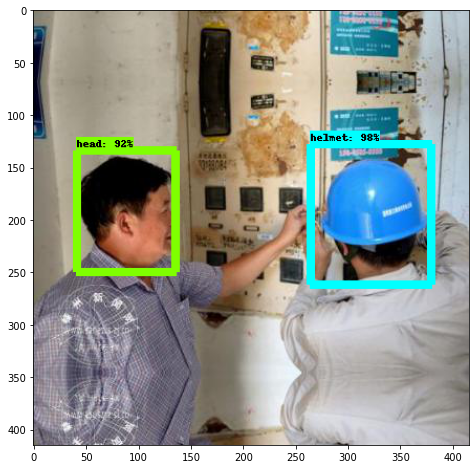

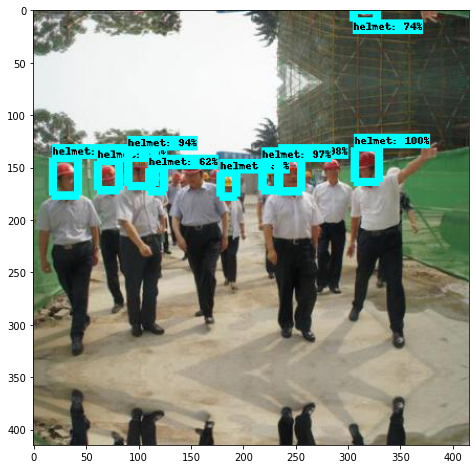

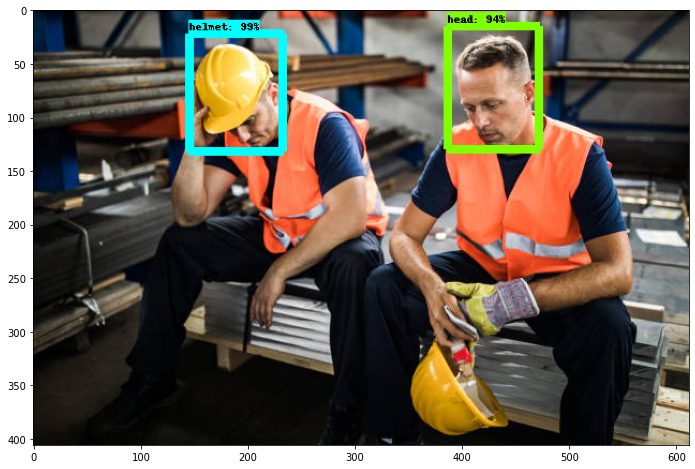

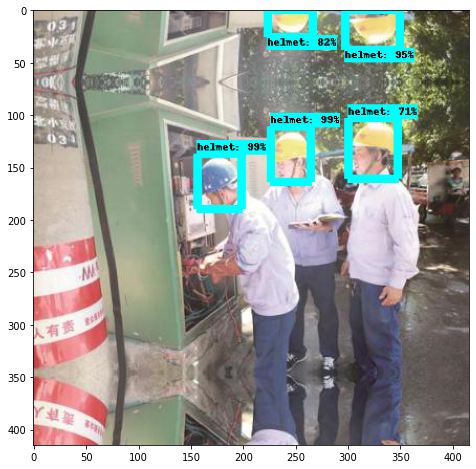

In [147]:

for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=8)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)